# The Annotated Transformer

Apr 3, 2018

In [ ]:
from IPython.display import Image
Image(filename='images/aiayn.png')

![png](imgs/the-annotated-transformer_0_0.png)

在过去的一年中，[“注意就是您所需要的一切”中的“](https://arxiv.org/abs/1706.03762)变形金刚[”](https://arxiv.org/abs/1706.03762)已经引起了很多人的关注。除了在翻译质量上取得重大改进外，它还为其他许多NLP任务提供了新的体系结构。论文本身写得很清楚，但是传统的看法是，很难正确实施。

在这篇文章中，我以逐行实施的形式介绍了本文的“注释”版本。我已经重新排序并从原始论文中删除了一些部分，并在全文中添加了评论。该文档本身是一个有效的笔记本，应完全可用。总共有400行库代码，可在4个GPU上每秒处理27,000个令牌。

要继续进行，您首先需要安装 [PyTorch](http://pytorch.org/)。完整的笔记本也可以在 [github](https://github.com/harvardnlp/annotated-transformer)或带有免费GPU的Google [Colab上](https://drive.google.com/file/d/1xQXSv6mtAOLXxEMi8RvaW8TW-7bvYBDF/view?usp=sharing)获得。

请注意，这仅仅是研究人员和感兴趣的开发人员的起点。此处的代码主要基于我们的[OpenNMT](http://opennmt.net/)软件包。（如果有帮助，请随时[引用](http://nlp.seas.harvard.edu/2018/04/03/attention.html#conclusion)。）对于模型检出的其他全服务实现， [Tensor2Tensor](https://github.com/tensorflow/tensor2tensor)（tensorflow）和 [Sockeye](https://github.com/awslabs/sockeye)（mxnet）。

- 亚历山大·拉什（[@harvardnlp](https://twitter.com/harvardnlp)或srush@seas.harvard.edu），在Vincent Nguyen和Guillaume Klein的帮助下


# Prelims

In [2]:
# !pip install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl numpy matplotlib spacy torchtext seaborn 
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

> 目录
>
> - [预赛](http://nlp.seas.harvard.edu/2018/04/03/attention.html#prelims)
> - [背景](http://nlp.seas.harvard.edu/2018/04/03/attention.html#background)
> - 模型架构
>   - 编码器和解码器堆栈
>     - [编码器](http://nlp.seas.harvard.edu/2018/04/03/attention.html#encoder)
>     - [解码器](http://nlp.seas.harvard.edu/2018/04/03/attention.html#decoder)
>     - [注意](http://nlp.seas.harvard.edu/2018/04/03/attention.html#attention)
>     - [注意在我们模型中的应用](http://nlp.seas.harvard.edu/2018/04/03/attention.html#applications-of-attention-in-our-model)
>   - [位置前馈网络](http://nlp.seas.harvard.edu/2018/04/03/attention.html#position-wise-feed-forward-networks)
>   - [嵌入和Softmax](http://nlp.seas.harvard.edu/2018/04/03/attention.html#embeddings-and-softmax)
>   - [位置编码](http://nlp.seas.harvard.edu/2018/04/03/attention.html#positional-encoding)
>   - [全模型](http://nlp.seas.harvard.edu/2018/04/03/attention.html#full-model)
> - 训练
>   - [批次和遮罩](http://nlp.seas.harvard.edu/2018/04/03/attention.html#batches-and-masking)
>   - [训练循环](http://nlp.seas.harvard.edu/2018/04/03/attention.html#training-loop)
>   - [培训数据和批处理](http://nlp.seas.harvard.edu/2018/04/03/attention.html#training-data-and-batching)
>   - [硬件和时间表](http://nlp.seas.harvard.edu/2018/04/03/attention.html#hardware-and-schedule)
>   - [优化器](http://nlp.seas.harvard.edu/2018/04/03/attention.html#optimizer)
>   - 正则化
>     - [标签平滑](http://nlp.seas.harvard.edu/2018/04/03/attention.html#label-smoothing)
> - 第一个例子
>   - [综合数据](http://nlp.seas.harvard.edu/2018/04/03/attention.html#synthetic-data)
>   - [损失计算](http://nlp.seas.harvard.edu/2018/04/03/attention.html#loss-computation)
>   - [贪婪解码](http://nlp.seas.harvard.edu/2018/04/03/attention.html#greedy-decoding)
> - 真实的例子
>   - [资料载入](http://nlp.seas.harvard.edu/2018/04/03/attention.html#data-loading)
>   - [迭代器](http://nlp.seas.harvard.edu/2018/04/03/attention.html#iterators)
>   - [多GPU训练](http://nlp.seas.harvard.edu/2018/04/03/attention.html#multi-gpu-training)
>   - [训练系统](http://nlp.seas.harvard.edu/2018/04/03/attention.html#training-the-system)
> - [附加组件：BPE，搜索，平均](http://nlp.seas.harvard.edu/2018/04/03/attention.html#additional-components-bpe-search-averaging)
> - 结果
>   - [注意可视化](http://nlp.seas.harvard.edu/2018/04/03/attention.html#attention-visualization)
> - [结论](http://nlp.seas.harvard.edu/2018/04/03/attention.html#conclusion)
>
> > 我的评论被引用了。正文全部来自论文本身。

# 背景

减少顺序计算的目标也构成了扩展神经GPU，ByteNet和ConvS2S的基础，它们全部使用卷积神经网络作为基本构建块，为所有输入和输出位置并行计算隐藏表示。在这些模型中，关联来自两个任意输入或输出位置的信号所需的操作数在位置之间的距离中增加，对于ConvS2S线性增长，而对于ByteNet则对数增长。这使得学习远处位置之间的依赖性变得更加困难。在“transformer”中，此操作被减少为恒定的操作次数，尽管这是由于平均注意力加权位置而导致有效分辨率降低的代价，我们用多头注意力来抵消这种效果。

自我注意，有时也称为内部注意，是一种与单个序列的不同位置相关的注意力机制，目的是计算序列的表示形式。自我注意已成功用于各种任务中，包括阅读理解，抽象总结，文本蕴涵和学习与任务无关的句子表示。端到端内存网络基于递归注意机制，而不是序列对齐的递归，并且已被证明在简单语言问答和语言建模任务中表现良好。

据我们所知，Transformer是第一个完全依靠自我注意力来计算其输入和输出表示的转导模型，而无需使用序列对齐的RNN或卷积。

# 模型架构

大多数竞争性神经序列转导模型具有编码器-解码器结构[（引用）](https://arxiv.org/abs/1409.0473)。在此, 编码器映射一个符号表示的输入序列 (x1,…,xn)(x1,…,xn) 到一个连续表示的序列 **z**=(z1,…,zn)z=(z1,…,zn). 通过 **z**z, 解码器按一次一个符号的方式生产一个输出序列 (y1,…,ym)(y1,…,ym) . 模型的每一步都是自动回归的 [（引用）](https://arxiv.org/abs/1308.0850)，在生成下一个时，会将先前生成的符号用作附加输入。

In [3]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many 
    other models.
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        return self.decode(self.encode(src, src_mask), src_mask,
                            tgt, tgt_mask)
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)
class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

变压器遵循这种总体架构，对编码器和解码器使用堆叠式自注意力和逐点，全连接层，分别如图1的左半部分和右半部分所示。

In [ ]:
Image(filename='images/ModalNet-21.png')

![png](imgs/the-annotated-transformer_14_0.png)

## 编码器和解码器堆栈

### 编码器

编码器由相同的N=6的层栈构成。

In [4]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

我们 在两个子层的每一层周围都采用了残余连接[（引用）](https://arxiv.org/abs/1512.03385)，然后进行层归一化 [（引用）](https://arxiv.org/abs/1607.06450)。

In [5]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

也就是说, 每个子层的输出 is $LayerNorm (x+\text { Sublayer }(x))$, 在这里 $Sublayer (x)$ is  sub-layer 自己实现的函数. 我们应用差 [（引用）](http://jmlr.org/papers/v15/srivastava14a.html)到每个子层的输出，然后将其加入到该子层的输入和归一化。

为了促进这些残留连接，模型中的所有子层以及嵌入层均产生尺寸为$d_{\text {model}}=512$

In [6]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

每层都有两个子层。第一个是多头自我关注机制，第二个是简单的位置完全连接的前馈网络。

In [7]:
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

### 解码器

编码器也是由相同的$N=6$的层栈构成。

In [8]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

除了每个编码器层中的两个子层之外，解码器还插入第三子层，该第三子层对编码器堆栈的输出执行多头关注。与编码器类似，我们在每个子层周围采用残余连接，然后进行层归一化。

In [10]:
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
 
    def forward(self, x, memory, src_mask, tgt_mask):
        "Follow Figure 1 (right) for connections."
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

我们还修改了解码器堆栈中的自我注意子层，以防止位置关注后续位置。这种掩盖结合输出嵌入偏移一个位置这一事实，可以确保对位置i的预测只能取决于位置小于i的已知输出。

In [11]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

In [55]:
a=np.triu(np.ones((1,3,3)))
torch.from_numpy(a)==0

tensor([[[False, False, False],
         [ True, False, False],
         [ True,  True, False]]])

> *注意框下方显示每个tgt单词（行）允许查看的位置（列）。在训练期间，由于将来出现的单词而使单词被阻止。*

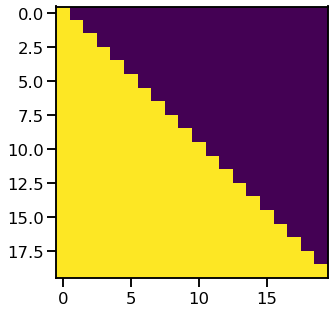

In [12]:
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])
None

![png](imgs/the-annotated-transformer_31_0.png)

### 注意

注意功能可以描述为将查询和一组键值对映射到输出，其中查询，键，值和输出都是向量。将输出计算为值的加权总和，其中分配给每个值的权重是通过查询与相应键的兼容性函数来计算的。

我们将我们的特别关注称为“点状产品关注度”。输入包含维度为d的查询和键$d_{k}$，以及维度d的值$d_{v}$。我们用所有键计算查询的点积，将每个键除以 $\sqrt{d_{k}}$，然后应用softmax函数来获取值的权重。

In [ ]:
Image(filename='images/ModalNet-19.png')

![png](imgs/the-annotated-transformer_33_0.png)

在实际应用中，我们同时计算一组查询的注意函数，并将其组合成一个矩阵$Q$。键和值也被打包成矩阵$K$和$V$。我们将输出矩阵计算为：
$$
\text { Attention }(Q, K, V)=\operatorname{softmax}\left(\frac{Q K^{T}}{\sqrt{d_{k}}}\right) V
$$

In [13]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

两个最常用的注意力功能是加性注意力 [（引用）](https://arxiv.org/abs/1409.0473)和点乘（乘法）注意力。点积注意与我们的算法相同，只是比例因子为$\frac{1}{\sqrt{d_{k}}}$。加性注意事项使用具有单个隐藏层的前馈网络来计算兼容性函数。尽管两者在理论上的复杂度相似，但是在实践中点积的关注要快得多，并且空间效率更高，因为可以使用高度优化的矩阵乘法代码来实现。

而对于较小的$d_{k}$两种机制的表现相似，加性注意的效果优于点积的注意，而无需针对较大的$d$进行缩放 $d_{k}$ [（引用）](https://arxiv.org/abs/1703.03906)。我们怀疑对于较大的$d_{k}$，点积的大小会增大，从而将$softmax$函数推入梯度极小的区域（为说明点积变大的原因，请假设$q$的分量$q$和$k$是均值为0的独立随机变量0和方差1个。于是他们点的产品，$q \cdot k=\sum_{i=1}^{d k} q_{i} k_{i}$平均值为0和方差 $d_{k}$。为了抵消这种影响，我们将点积缩放$\frac{1}{\sqrt{d_{k}}}$。

In [ ]:
Image(filename='images/ModalNet-20.png')

![png](imgs/the-annotated-transformer_38_0.png)

多头注意力使模型可以共同关注来自不同位置的不同表示子空间的信息。 对于一个注意力集中的头部，平均抑制了这一点。
$$
\begin{aligned}
&\text { MultiHead( }Q, K, V)=\text { Concat (head }_{1}, \ldots, \text { head }_{\mathrm{h}} \text { ) } W^{O}\\
&\text { where head }_{\mathrm{i}}=\text { Attention }\left(Q W_{i}^{Q}, K W_{i}^{K}, V W_{i}^{V}\right)
\end{aligned}
$$

这里投影是参数矩阵 $W_{i}^{Q} \in \mathbb{R}^{d_{\text {model }} d_{k}}, W_{i}^{K} \in \mathbb{R}^{d_{\text {model }} d_{k}}, W_{i}^{V} \in \mathbb{R}^{d_{\text {model}} d_{v}} \text { and } W^{O} \in \mathbb{R}^{h d_{v} \times d_{\text {model }}}
$. 在这项工作中，我们采用$ h = 8 $平行注意层或头部。 对于每一个，我们使用$d_{k}=d_{y}=d_{\text {model}}/h=64$。 由于每个头部的尺寸减小，因此总的计算成本类似于具有全尺寸的单头注意力的计算成本。

In [ ]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

In [26]:
a=torch.Tensor([1,2,3,4])

### 注意在我们模型中的应用

Transformer以三种不同的方式使用多头注意：

1）在“编码器-解码器注意”层中，查询来自上一个解码器层，而存储键和值来自编码器的输出。这允许解码器中的每个位置都参与输入序列中的所有位置。这模仿了诸如[（cite）之](https://arxiv.org/abs/1609.08144)类的序列到序列模型中的典型编码器-解码器注意机制 。

2）编码器包含自我注意层。在自我关注层中，所有键，值和查询都来自同一位置，在这种情况下，是编码器中上一层的输出。编码器中的每个位置都可以覆盖编码器上一层中的所有位置。

3）类似地，解码器中的自我注意层允许解码器中的每个位置都参与解码器中的所有位置，直到该位置为止。我们需要防止解码器中向左流动信息，以保留自回归属性。我们通过屏蔽掉（设置来实现此的缩放点状产品关注内部-∞-∞）softmax输入中与非法连接相对应的所有值。

## 位置前馈网络

除了关注子层之外，我们的编码器和解码器中的每个层还包含一个完全连接的前馈网络，该网络被分别并相同地应用于每个位置。这由两个线性变换组成，两个线性变换之间具有ReLU激活。

$$
\operatorname{FFN}(x)=\max \left(0, x W_{1}+b_{1}\right) W_{2}+b_{2}
$$

虽然线性变换在不同位置上相同，但是它们使用不同的参数。 描述此问题的另一种方式是将其与内核大小为1的两个卷积进行比较。输入和输出的维数为$d_{model}=512$，而内层的维数为$d_{ff}=2048$。

In [ ]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

## 嵌入和Softmax

与其他序列转导模型类似，我们使用学习的嵌入将输入标记和输出标记转换为维度$d_{model}$的向量。我们还使用通常学习的线性变换和softmax函数将解码器输出转换为预测的下一个令牌概率。在我们的模型中，我们在两个嵌入层和pre-softmax线性变换之间共享相同的权重矩阵，类似于 [（cite）](https://arxiv.org/abs/1608.05859)。在嵌入层中，我们将这些权重乘以$\sqrt{d_{\text {model }}}$。

In [ ]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

## 位置编码

由于我们的模型不包含重复性和卷积，因此为了使模型能够利用序列的顺序，我们必须注入一些有关令牌在序列中的相对或绝对位置的信息。为此，我们在编码器和解码器堆栈底部的输入嵌入中添加“位置编码”。位置编码的维数为 d模型作为嵌入，以便可以将两者相加。位置编码有很多选择，学习的和固定的 [（引用）](https://arxiv.org/pdf/1705.03122.pdf)。

在这项工作中，我们使用不同频率的正弦和余弦函数:$PE_{(pos, 2i)}=\sin (pos / 10000^{2i / d_{mode }})$

$PE_{(pos, 2i)}=\cos (pos / 10000^{2i / d_{mode }})$其中$pos$是位置，$i$是尺寸。 即，位置编码的每个维度对应于正弦曲线。 波长形成从$2π$到$10000⋅2π$的几何级数。 我们选择此函数是因为我们假设它会允许模型轻松学习相对位置的参加，因为对于任何固定的偏移$k$，$PE_{pos+k}$都可以表示为$PE_{pos}$.

此外，我们对编码器和解码器堆栈中的嵌入和位置编码的总和应用了dropout。 对于基本模型，我们使用$P_{drop} = 0.1$的比率。

In [ ]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)

In [64]:
# calculate: 5**[1,2,3,4]
torch.exp(torch.Tensor([1,2,3,4])*math.log(5))

tensor([  5.0000,  25.0000, 125.0000, 625.0001])

In [68]:
10**0.5

3.1622776601683795

> *在位置编码下方，将基于位置添加正弦波。对于每个维度，波的频率和偏移都不同。*

In [ ]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])
None

![png](imgs/the-annotated-transformer_49_0.png)

我们还尝试使用学习的位置嵌入 [（引用）](https://arxiv.org/pdf/1705.03122.pdf)代替，发现这两个版本产生了几乎相同的结果。我们选择正弦曲线版本是因为它可以使模型外推到比训练过程中遇到的序列更长的序列长度。

## 全模型

> *在这里，我们定义一个接受超参数并生成完整模型的函数。*

In [ ]:
def make_model(src_vocab, tgt_vocab, N=6, 
               d_model=512, d_ff=2048, h=8, dropout=0.1):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), 
                             c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab))
    
    # This was important from their code. 
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model
# Small example model.
tmp_model = make_model(10, 10, 2)
None

# 训练

本节描述了我们模型的训练方案。

> *我们停下来快速介绍一下训练标准编码器-解码器模型所需的一些工具。首先，我们定义一个批处理对象，其中包含用于训练的src和目标句子，以及构造遮罩。*

## 批次和遮罩

In [ ]:
class Batch:
    "Object for holding a batch of data with mask during training."
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = \
                self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()
    
    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask

> *接下来，我们创建一个通用的训练和评分功能来跟踪损失。我们传入一个通用损失计算函数，该函数还处理参数更新。*

## 训练循环

In [ ]:
def run_epoch(data_iter, model, loss_compute):
    "Standard Training and Logging Function"
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(batch.src, batch.trg, 
                            batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                    (i, loss / batch.ntokens, tokens / elapsed))
            start = time.time()
            tokens = 0
    return total_loss / total_tokens

## 培训数据和批处理

我们对标准的WMT 2014英语-德语数据集进行了培训，该数据集包含约450万个句子对。句子使用字节对编码进行编码，字节对编码具有约37000个令牌的共享源-目标词汇表。对于英语-法语，我们使用了更大的WMT 2014英语-法语数据集，该数据集由3600万个句子组成，并将标记拆分成32000个字词词汇。

句子对按近似的序列长度进行批处理。每个训练批次包含一组句子对，其中包含大约25000个源标记和25000个目标标记。

> *我们将使用火炬文本进行批处理。这将在下面更详细地讨论。在这里，我们在torchtext函数中创建批处理，以确保将填充到最大批处理大小的批处理大小不超过阈值（如果我们有8 gpu，则为25000）。*

In [ ]:
global max_src_in_batch, max_tgt_in_batch
def batch_size_fn(new, count, sofar):
    "Keep augmenting batch and calculate total number of tokens + padding."
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch,  len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)

## 硬件和时间表

我们在一台装有8个NVIDIA P100 GPU的计算机上训练了模型。对于使用本文所述的超参数的基本模型，每个训练步骤大约需要0.4秒。我们对基本模型进行了总共100,000步或12个小时的训练。对于我们的大型模型，步长为1.0秒。大型模型接受了300,000步（3.5天）的培训。

## 优化器

我们使用Adam优化器 [(cite)](https://arxiv.org/abs/1412.6980)并使用参数 $\beta_{1}=0.9, \beta_{2}=0.98 \text { and } \epsilon=10^{-9}
$. 我们根据下面的公司在训练中改变学习率:
$$rate=d_{model }^{-0.5} \cdot min (step_{-} \text {num}^{-0.5}, {step}_{-} \text{num} \cdot warmup_{-} \text {steps}^{-1.5}) $$
这对应于第一个$warmup_{s}steps$训练步中学习率的增加，以及按步数的平方根成反比减小学习率。 我们使用的 $warmup_{s}steps=4000$.

> 注意：这部分非常重要。需要训练模型的这种设置。

In [ ]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

> *不同模型大小和优化超参数的此模型曲线的示例。*

In [ ]:
# Three settings of the lrate hyperparameters.
opts = [NoamOpt(512, 1, 4000, None), 
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None)]
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])

![png](imgs/the-annotated-transformer_69_0.png)

## 正则化

### 标签平滑

在训练期间，我们采用了值$ϵ_{ls}=0.1$的标签平滑处理 [(cite)](https://arxiv.org/abs/1512.00567). 这伤害了困惑，因为模型学会了更加不确定，但提高了准确性和BLEU分数。

> *我们使用KL div损失实现标签平滑。而不是使用单一目标分布，我们创建的分布具有`confidence`正确的单词，其余的`smoothing`质量分布在整个词汇表中。*

In [ ]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))

Object `torch.union` not found.


In [173]:
a=torch.Tensor([[1,2,3,4]])
a.squeeze(0).unsqueeze(0)

tensor([[1., 2., 3., 4.]])

In [200]:
a=set([1,2,3,4])
b=set([2,5])
a.union(b)

{1, 2, 3, 4, 5}

> *在这里，我们可以看到一个示例，说明如何根据置信度将质量分配给单词。*

In [ ]:
# Example of label smoothing.
crit = LabelSmoothing(5, 0, 0.4)
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0], 
                             [0, 0.2, 0.7, 0.1, 0]])
v = crit(Variable(predict.log()), 
         Variable(torch.LongTensor([2, 1, 0])))

# Show the target distributions expected by the system.
plt.imshow(crit.true_dist)

![png](imgs/the-annotated-transformer_74_0.png)

> *如果标签平滑化对于给定的选择非常有信心，则标签平滑实际上开始对模型造成不利影响。*

In [ ]:
crit = LabelSmoothing(5, 0, 0.1)
def loss(x):
    d = x + 3 * 1
    predict = torch.FloatTensor([[0, x / d, 1 / d, 1 / d, 1 / d],
                                 ])
    #print(predict)
    return crit(Variable(predict.log()),
                 Variable(torch.LongTensor([1]))).data[0]
plt.plot(np.arange(1, 100), [loss(x) for x in range(1, 100)])

![png](imgs/the-annotated-transformer_76_0.png)

# 第一个例子

> *我们可以从尝试一个简单的复制任务开始。给定来自少量词汇的随机输入符号集，目标是产生回相同的符号。*

## 综合数据

In [ ]:
def data_gen(V, batch, nbatches):
    "Generate random data for a src-tgt copy task."
    for i in range(nbatches):
        data = torch.from_numpy(np.random.randint(1, V, size=(batch, 10)))
        data[:, 0] = 1
        src = Variable(data, requires_grad=False)
        tgt = Variable(data, requires_grad=False)
        yield Batch(src, tgt, 0)

## 损失计算

In [ ]:
class SimpleLossCompute:
    "A simple loss compute and train function."
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt
        
    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), 
                              y.contiguous().view(-1)) / norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.data[0] * norm

## 贪婪解码

In [ ]:
# Train the simple copy task.
V = 11
criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
model = make_model(V, V, N=2)
model_opt = NoamOpt(model.src_embed[0].d_model, 1, 400,
        torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

for epoch in range(10):
    model.train()
    run_epoch(data_gen(V, 30, 20), model, 
              SimpleLossCompute(model.generator, criterion, model_opt))
    model.eval()
    print(run_epoch(data_gen(V, 30, 5), model, 
                    SimpleLossCompute(model.generator, criterion, None)))

```
Epoch Step: 1 Loss: 3.023465 Tokens per Sec: 403.074173
Epoch Step: 1 Loss: 1.920030 Tokens per Sec: 641.689380
1.9274832487106324
Epoch Step: 1 Loss: 1.940011 Tokens per Sec: 432.003378
Epoch Step: 1 Loss: 1.699767 Tokens per Sec: 641.979665
1.657595729827881
Epoch Step: 1 Loss: 1.860276 Tokens per Sec: 433.320240
Epoch Step: 1 Loss: 1.546011 Tokens per Sec: 640.537198
1.4888023376464843
Epoch Step: 1 Loss: 1.682198 Tokens per Sec: 432.092305
Epoch Step: 1 Loss: 1.313169 Tokens per Sec: 639.441857
1.3485562801361084
Epoch Step: 1 Loss: 1.278768 Tokens per Sec: 433.568756
Epoch Step: 1 Loss: 1.062384 Tokens per Sec: 642.542067
0.9853351473808288
Epoch Step: 1 Loss: 1.269471 Tokens per Sec: 433.388727
Epoch Step: 1 Loss: 0.590709 Tokens per Sec: 642.862135
0.5686767101287842
Epoch Step: 1 Loss: 0.997076 Tokens per Sec: 433.009746
Epoch Step: 1 Loss: 0.343118 Tokens per Sec: 642.288427
0.34273059368133546
Epoch Step: 1 Loss: 0.459483 Tokens per Sec: 434.594030
Epoch Step: 1 Loss: 0.290385 Tokens per Sec: 642.519464
0.2612409472465515
Epoch Step: 1 Loss: 1.031042 Tokens per Sec: 434.557008
Epoch Step: 1 Loss: 0.437069 Tokens per Sec: 643.630322
0.4323212027549744
Epoch Step: 1 Loss: 0.617165 Tokens per Sec: 436.652626
Epoch Step: 1 Loss: 0.258793 Tokens per Sec: 644.372296
0.27331129014492034
```

> *为了简单起见，此代码使用贪婪解码来预测翻译。*

In [ ]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len-1):
        out = model.decode(memory, src_mask, 
                           Variable(ys), 
                           Variable(subsequent_mask(ys.size(1))
                                    .type_as(src.data)))
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.data[0]
        ys = torch.cat([ys, 
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys

model.eval()
src = Variable(torch.LongTensor([[1,2,3,4,5,6,7,8,9,10]]) )
src_mask = Variable(torch.ones(1, 1, 10) )
print(greedy_decode(model, src, src_mask, max_len=10, start_symbol=1))

```
    1     2     3     4     5     6     7     8     9    10
[torch.LongTensor of size 1x10]
```

> # 真实的例子
>
> > *现在，我们考虑一个使用IWSLT德语-英语翻译任务的真实示例。该任务比本文中考虑的WMT任务小得多，但它说明了整个系统。我们还将展示如何使用多GPU处理使其真正快速。*

In [ ]:
#!pip install torchtext spacy
#!python -m spacy download en
#!python -m spacy download de

## 资料载入

> *我们将使用torchtext和spacy加载数据集以进行标记化。*

In [ ]:
# For data loading.
from torchtext import data, datasets

if True:
    import spacy
    spacy_de = spacy.load('de')
    spacy_en = spacy.load('en')

    def tokenize_de(text):
        return [tok.text for tok in spacy_de.tokenizer(text)]

    def tokenize_en(text):
        return [tok.text for tok in spacy_en.tokenizer(text)]

    BOS_WORD = '<s>'
    EOS_WORD = '</s>'
    BLANK_WORD = "<blank>"
    SRC = data.Field(tokenize=tokenize_de, pad_token=BLANK_WORD)
    TGT = data.Field(tokenize=tokenize_en, init_token = BOS_WORD, 
                     eos_token = EOS_WORD, pad_token=BLANK_WORD)

    MAX_LEN = 100
    train, val, test = datasets.IWSLT.splits(
        exts=('.de', '.en'), fields=(SRC, TGT), 
        filter_pred=lambda x: len(vars(x)['src']) <= MAX_LEN and 
            len(vars(x)['trg']) <= MAX_LEN)
    MIN_FREQ = 2
    SRC.build_vocab(train.src, min_freq=MIN_FREQ)
    TGT.build_vocab(train.trg, min_freq=MIN_FREQ)

> *批处理对速度至关重要。我们希望批次非常均匀，并且填充量绝对最少。为此，我们必须对默认的torchtext批处理有所了解。此代码修补了它们的默认批处理，以确保我们搜索足够多的句子以查找紧凑的批处理。*

## 迭代器

In [ ]:
class MyIterator(data.Iterator):
    def create_batches(self):
        if self.train:
            def pool(d, random_shuffler):
                for p in data.batch(d, self.batch_size * 100):
                    p_batch = data.batch(
                        sorted(p, key=self.sort_key),
                        self.batch_size, self.batch_size_fn)
                    for b in random_shuffler(list(p_batch)):
                        yield b
            self.batches = pool(self.data(), self.random_shuffler)
            
        else:
            self.batches = []
            for b in data.batch(self.data(), self.batch_size,
                                          self.batch_size_fn):
                self.batches.append(sorted(b, key=self.sort_key))

def rebatch(pad_idx, batch):
    "Fix order in torchtext to match ours"
    src, trg = batch.src.transpose(0, 1), batch.trg.transpose(0, 1)
    return Batch(src, trg, pad_idx)

## 多GPU训练

> *最后，要真正针对快速培训，我们将使用multi-gpu。该代码实现了多GPU字生成。它不是特定于变压器的，因此我不会赘述。想法是在训练时将单词生成分为多个块，以在许多不同的GPU上并行处理。我们使用pytorch并行原语进行此操作：*

- 复制-将模块拆分到不同的GPU上。
- 分散-将批次拆分到不同的GPU
- parallel_apply-将模块应用于不同GPU上的批处理
- 收集-将分散的数据拉回到一个GPU上。
- nn.DataParallel-一种特殊的模块包装器，在评估之前将其全部调用。

In [ ]:
# Skip if not interested in multigpu.
class MultiGPULossCompute:
    "A multi-gpu loss compute and train function."
    def __init__(self, generator, criterion, devices, opt=None, chunk_size=5):
        # Send out to different gpus.
        self.generator = generator
        self.criterion = nn.parallel.replicate(criterion, 
                                               devices=devices)
        self.opt = opt
        self.devices = devices
        self.chunk_size = chunk_size
        
    def __call__(self, out, targets, normalize):
        total = 0.0
        generator = nn.parallel.replicate(self.generator, 
                                                devices=self.devices)
        out_scatter = nn.parallel.scatter(out, 
                                          target_gpus=self.devices)
        out_grad = [[] for _ in out_scatter]
        targets = nn.parallel.scatter(targets, 
                                      target_gpus=self.devices)

        # Divide generating into chunks.
        chunk_size = self.chunk_size
        for i in range(0, out_scatter[0].size(1), chunk_size):
            # Predict distributions
            out_column = [[Variable(o[:, i:i+chunk_size].data, 
                                    requires_grad=self.opt is not None)] 
                           for o in out_scatter]
            gen = nn.parallel.parallel_apply(generator, out_column)

            # Compute loss. 
            y = [(g.contiguous().view(-1, g.size(-1)), 
                  t[:, i:i+chunk_size].contiguous().view(-1)) 
                 for g, t in zip(gen, targets)]
            loss = nn.parallel.parallel_apply(self.criterion, y)

            # Sum and normalize loss
            l = nn.parallel.gather(loss, 
                                   target_device=self.devices[0])
            l = l.sum()[0] / normalize
            total += l.data[0]

            # Backprop loss to output of transformer
            if self.opt is not None:
                l.backward()
                for j, l in enumerate(loss):
                    out_grad[j].append(out_column[j][0].grad.data.clone())

        # Backprop all loss through transformer.            
        if self.opt is not None:
            out_grad = [Variable(torch.cat(og, dim=1)) for og in out_grad]
            o1 = out
            o2 = nn.parallel.gather(out_grad, 
                                    target_device=self.devices[0])
            o1.backward(gradient=o2)
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return total * normalize

> *现在我们创建模型，准则，优化器，数据迭代器和并行化*

In [ ]:
# GPUs to use
devices = [0, 1, 2, 3]
if True:
    pad_idx = TGT.vocab.stoi["<blank>"]
    model = make_model(len(SRC.vocab), len(TGT.vocab), N=6)
    model.cuda()
    criterion = LabelSmoothing(size=len(TGT.vocab), padding_idx=pad_idx, smoothing=0.1)
    criterion.cuda()
    BATCH_SIZE = 12000
    train_iter = MyIterator(train, batch_size=BATCH_SIZE, device=0,
                            repeat=False, sort_key=lambda x: (len(x.src), len(x.trg)),
                            batch_size_fn=batch_size_fn, train=True)
    valid_iter = MyIterator(val, batch_size=BATCH_SIZE, device=0,
                            repeat=False, sort_key=lambda x: (len(x.src), len(x.trg)),
                            batch_size_fn=batch_size_fn, train=False)
    model_par = nn.DataParallel(model, device_ids=devices)
None

> *现在我们训练模型。我将进行一些预热步骤，但是其他所有操作都使用默认参数。在具有4个Tesla V100的AWS p3.8xlarge上，此速度以每秒约27,000个令牌运行，批处理大小为12,000*

## 训练系统

In [ ]:
#!wget https://s3.amazonaws.com/opennmt-models/iwslt.pt
if False:
    model_opt = NoamOpt(model.src_embed[0].d_model, 1, 2000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
    for epoch in range(10):
        model_par.train()
        run_epoch((rebatch(pad_idx, b) for b in train_iter), 
                  model_par, 
                  MultiGPULossCompute(model.generator, criterion, 
                                      devices=devices, opt=model_opt))
        model_par.eval()
        loss = run_epoch((rebatch(pad_idx, b) for b in valid_iter), 
                          model_par, 
                          MultiGPULossCompute(model.generator, criterion, 
                          devices=devices, opt=None))
        print(loss)
else:
    model = torch.load("iwslt.pt")

> *训练后，我们可以对模型进行解码，以生成一组翻译。在这里，我们只翻译验证集中的第一句话。该数据集非常小，因此带有贪婪搜索的翻译相当准确。*

In [ ]:
for i, batch in enumerate(valid_iter):
    src = batch.src.transpose(0, 1)[:1]
    src_mask = (src != SRC.vocab.stoi["<blank>"]).unsqueeze(-2)
    out = greedy_decode(model, src, src_mask, 
                        max_len=60, start_symbol=TGT.vocab.stoi["<s>"])
    print("Translation:", end="\t")
    for i in range(1, out.size(1)):
        sym = TGT.vocab.itos[out[0, i]]
        if sym == "</s>": break
        print(sym, end =" ")
    print()
    print("Target:", end="\t")
    for i in range(1, batch.trg.size(0)):
        sym = TGT.vocab.itos[batch.trg.data[i, 0]]
        if sym == "</s>": break
        print(sym, end =" ")
    print()
    break
Translation:	<unk> <unk> . In my language , that means , thank you very much . 
Gold:	<unk> <unk> . It means in my language , thank you very much . 

# 附加组件：BPE，搜索，平均

> 因此，这主要涵盖了变压器模型本身。我们没有明确涵盖四个方面。我们还在[OpenNMT-py中](https://github.com/opennmt/opennmt-py)实现了所有这些附加功能。

> 1）BPE /词段：我们可以使用一个库来将数据首先预处理为子词单元。请参阅Rico Sennrich的子[词nmt](https://github.com/rsennrich/subword-nmt)实现。这些模型将转换训练数据，如下所示：

▁Die ▁Protokoll datei ▁kann ▁ heimlich ▁per ▁E - Mail ▁oder ▁FTP ▁an ▁einen ▁bestimmte n ▁Empfänger ▁gesendet ▁werden .

>  2）共享嵌入：当使用共享词汇的BPE时，我们可以在源/目标/生成器之间共享相同的权重向量。有关详细信息，请参见 [（引用）](https://arxiv.org/abs/1608.05859)。要将其添加到模型中，只需执行以下操作：

In [ ]:
if False:
    model.src_embed[0].lut.weight = model.tgt_embeddings[0].lut.weight
    model.generator.lut.weight = model.tgt_embed[0].lut.weight

> 3）光束搜索：这有点太复杂，无法在此处进行介绍。有关 pytorch的实现，请参见[OpenNMT-py](https://github.com/OpenNMT/OpenNMT-py/blob/master/onmt/translate/Beam.py)。

> 4）模型平均：本文将最后k个检查点平均，以产生集合效果。如果有很多模型，我们可以在事后执行：

In [ ]:
def average(model, models):
    "Average models into model"
    for ps in zip(*[m.params() for m in [model] + models]):
        p[0].copy_(torch.sum(*ps[1:]) / len(ps[1:]))

# 结果

在WMT 2014英语到德语的翻译任务中，大型变压器模型（表2中的变压器（大））比以前报告的最佳模型（包括合奏）高出2.0 BLEU，建立了新的状态art BLEU得分为28.4。表3的底部列出了该模型的配置。在8个P100 GPU上进行了3.5天的培训。甚至我们的基本模型都超过了以前发布的所有模型和集合，而其培训成本只是任何竞争模型的一小部分。

在2014年WMT英语到法语翻译任务中，我们的大型模型的BLEU得分达到41.0，优于以前发布的所有单个模型，而培训费用不到以前的最新水平的1/4模型。为英语到法语训练的Transformer（大型）模型使用的辍学率Pdrop = 0.1，而不是0.3。

In [ ]:
Image(filename="images/results.png")

![png](imgs/the-annotated-transformer_113_0.png)

> 我们在此处编写的代码是基本模型的一个版本。这里有此系统的完整培训版本 [（示例模型）](http://opennmt.net/Models-py/)。
>
> 通过上一节中的其他扩展，在EN-DE WMT上，OpenNMT-py复制达到26.9。在这里，我已将这些参数加载到我们的重新实现中。

In [ ]:
!wget https://s3.amazonaws.com/opennmt-models/en-de-model.pt
model, SRC, TGT = torch.load("en-de-model.pt")
model.eval()
sent = "▁The ▁log ▁file ▁can ▁be ▁sent ▁secret ly ▁with ▁email ▁or ▁FTP ▁to ▁a ▁specified ▁receiver".split()
src = torch.LongTensor([[SRC.stoi[w] for w in sent]])
src = Variable(src)
src_mask = (src != SRC.stoi["<blank>"]).unsqueeze(-2)
out = greedy_decode(model, src, src_mask, 
                    max_len=60, start_symbol=TGT.stoi["<s>"])
print("Translation:", end="\t")
trans = "<s> "
for i in range(1, out.size(1)):
    sym = TGT.itos[out[0, i]]
    if sym == "</s>": break
    trans += sym + " "
print(trans)
Translation:	<s> ▁Die ▁Protokoll datei ▁kann ▁ heimlich ▁per ▁E - Mail ▁oder ▁FTP ▁an ▁einen ▁bestimmte n ▁Empfänger ▁gesendet ▁werden . 

## 注意可视化

> *即使使用贪婪的解码器，翻译效果也相当不错。我们可以进一步对其进行可视化，以查看关注的每一层都在发生什么*

In [ ]:
tgt_sent = trans.split()
def draw(data, x, y, ax):
    seaborn.heatmap(data, 
                    xticklabels=x, square=True, yticklabels=y, vmin=0.0, vmax=1.0, 
                    cbar=False, ax=ax)
    
for layer in range(1, 6, 2):
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    print("Encoder Layer", layer+1)
    for h in range(4):
        draw(model.encoder.layers[layer].self_attn.attn[0, h].data, 
            sent, sent if h ==0 else [], ax=axs[h])
    plt.show()
    
for layer in range(1, 6, 2):
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    print("Decoder Self Layer", layer+1)
    for h in range(4):
        draw(model.decoder.layers[layer].self_attn.attn[0, h].data[:len(tgt_sent), :len(tgt_sent)], 
            tgt_sent, tgt_sent if h ==0 else [], ax=axs[h])
    plt.show()
    print("Decoder Src Layer", layer+1)
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    for h in range(4):
        draw(model.decoder.layers[layer].self_attn.attn[0, h].data[:len(tgt_sent), :len(sent)], 
            sent, tgt_sent if h ==0 else [], ax=axs[h])
    plt.show()

```
Encoder Layer 2
```

![png](imgs/the-annotated-transformer_119_1.png)

```
Encoder Layer 4
```

![png](imgs/the-annotated-transformer_119_3.png)

```
Encoder Layer 6
```

![png](imgs/the-annotated-transformer_119_5.png)

```
Decoder Self Layer 2
```

![png](imgs/the-annotated-transformer_119_7.png)

```
Decoder Src Layer 2
```

![png](imgs/the-annotated-transformer_119_9.png)

```
Decoder Self Layer 4
```

![png](imgs/the-annotated-transformer_119_11.png)

```
Decoder Src Layer 4
```

![png](imgs/the-annotated-transformer_119_13.png)

```
Decoder Self Layer 6
```

![png](imgs/the-annotated-transformer_119_15.png)

```
Decoder Src Layer 6
```

![png](imgs/the-annotated-transformer_119_17.png)

# 结论

> 希望该代码对将来的研究有用。如有任何问题，请与我们联系。如果您认为此代码有帮助，请查看我们的其他OpenNMT工具。

In [ ]:
@inproceedings{opennmt,
  author    = {Guillaume Klein and
               Yoon Kim and
               Yuntian Deng and
               Jean Senellart and
               Alexander M. Rush},
  title     = {OpenNMT: Open-Source Toolkit for Neural Machine Translation},
  booktitle = {Proc. ACL},
  year      = {2017},
  url       = {https://doi.org/10.18653/v1/P17-4012},
  doi       = {10.18653/v1/P17-4012}
}

> Cheers, srush